<a href="https://colab.research.google.com/github/kbpavan/Food.com-Reviews-Sentiment-Analysis/blob/master/Copy_of_Food.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
pip install apyori

  Created wheel for apyori: filename=apyori-1.1.2-cp36-none-any.whl size=5975 sha256=219eefafffa4b0b3bbc62f10d6db22d49727ebccb66b8a98ab1d28063f3d2880
  Stored in directory: /root/.cache/pip/wheels/5d/92/bb/474bbadbc8c0062b9eb168f69982a0443263f8ab1711a8cad0
Successfully built apyori


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
import string
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from  xgboost import XGBClassifier


from apyori import apriori
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import silhouette_score

from sklearn.metrics import roc_curve, auc
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')
from bs4 import BeautifulSoup

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

import pickle

from tqdm import tqdm
import os

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


**Reading the data**

In [0]:
Recipes = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Food_Data/RAW_recipes.csv')
Interactions  = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Food_Data/RAW_interactions.csv')


**Let's look at Interactions Data**

In [6]:
Interactions.head(n=5)

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


**Now Let's look at recipes Data**

In [7]:
Recipes.head(n=5)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


**Joining Interations data with the original recipe data**

In [8]:
Merged_Data2 = pd.merge(Recipes,Interactions, how="outer", left_on = 'id', right_on= 'recipe_id')
Merged_Data2.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1132367 entries, 0 to 1132366
Data columns (total 17 columns):
name              1132366 non-null object
id                1132367 non-null int64
minutes           1132367 non-null int64
contributor_id    1132367 non-null int64
submitted         1132367 non-null object
tags              1132367 non-null object
nutrition         1132367 non-null object
n_steps           1132367 non-null int64
steps             1132367 non-null object
description       1108857 non-null object
ingredients       1132367 non-null object
n_ingredients     1132367 non-null int64
user_id           1132367 non-null int64
recipe_id         1132367 non-null int64
date              1132367 non-null object
rating            1132367 non-null int64
review            1132198 non-null object
dtypes: int64(8), object(9)
memory usage: 155.5+ MB


In [9]:
len(Merged_Data2)

1132367

In [10]:
Merged_Data2.head(n=5)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,user_id,recipe_id,date,rating,review
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,4470,137739,2006-02-18,5,I used an acorn squash and recipe#137681 Swee...
1,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,593927,137739,2010-08-21,5,This was a nice change. I used butternut squas...
2,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,178427,137739,2011-12-05,5,Excellent recipe! I used butternut squash and ...
3,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,28603,31490,2002-08-19,0,"Have not tried this, but it sounds delicious. ..."
4,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,346277,31490,2006-08-27,5,This recipe was wonderful. Instead of using t...


**Let's find answers to some cool questions!**

**What is the best recipe by user ratings and number of reviews?**

In [11]:
rating = Merged_Data2[['name','rating','recipe_id']].groupby(['recipe_id','name'])['rating'].agg(['mean','count'])\
                                                        .rename(columns={"mean": "average_rating", "count": "No_of_Reviews"})
(rating.sort_values(by = ['average_rating','No_of_Reviews'], ascending= False)).head(n=10)


,,average_rating,No_of_Reviews
recipe_id,name,,
55309,caprese salad tomatoes italian marinated tomatoes,5.0,52
24768,berry cream cheese coffee cake,5.0,37
121941,kittencal s soft white baguette style bread,5.0,36
166669,kittencal s caesar tortellini salad,5.0,36
62754,linda s special potato salad,5.0,32
199171,broiled cinnamon toast,5.0,31
269136,earth bread,5.0,31
45107,strawberry cheese ring,5.0,28
94087,cranberry nut swirls,5.0,28


# Pre-processing of the data

**Some columns like nutritional values and ingredients are read as strings by python rather than list objects.**

1.   **We will now convert ingredients to list objects so that we can use them as iterables while text processing.**

2.   **We will convert nutritional values column to columns of nutritional  values so that we can use them for comparision of different recipes nutritional values.** 
 

**Coverting nutritional values column to columns of nutritional values**

In [12]:
NutriList=['cal', 'totalFat', 'sugar', 'sodium', 'protein', 'satFat', 'carbs']

NutriList_Columns = pd.DataFrame(Merged_Data2['nutrition'].apply(eval).to_list(),\
                        index=Merged_Data2.index\
                        ,columns=NutriList)

Merged_Data2 = Merged_Data2.join(NutriList_Columns)
Merged_Data2.head(5)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,user_id,recipe_id,date,rating,review,cal,totalFat,sugar,sodium,protein,satFat,carbs
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,4470,137739,2006-02-18,5,I used an acorn squash and recipe#137681 Swee...,51.5,0.0,13.0,0.0,2.0,0.0,4.0
1,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,593927,137739,2010-08-21,5,This was a nice change. I used butternut squas...,51.5,0.0,13.0,0.0,2.0,0.0,4.0
2,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,178427,137739,2011-12-05,5,Excellent recipe! I used butternut squash and ...,51.5,0.0,13.0,0.0,2.0,0.0,4.0
3,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,28603,31490,2002-08-19,0,"Have not tried this, but it sounds delicious. ...",173.4,18.0,0.0,17.0,22.0,35.0,1.0
4,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,346277,31490,2006-08-27,5,This recipe was wonderful. Instead of using t...,173.4,18.0,0.0,17.0,22.0,35.0,1.0


In [13]:
Merged_Data2['ingredients']

0          ['winter squash', 'mexican seasoning', 'mixed ...
1          ['winter squash', 'mexican seasoning', 'mixed ...
2          ['winter squash', 'mexican seasoning', 'mixed ...
3          ['prepared pizza crust', 'sausage patty', 'egg...
4          ['prepared pizza crust', 'sausage patty', 'egg...
                                 ...                        
1132362    ['hard-cooked eggs', 'mayonnaise', 'dijon must...
1132363    ['butter', 'eagle brand condensed milk', 'ligh...
1132364    ['granulated sugar', 'shortening', 'eggs', 'fl...
1132365    ['granulated sugar', 'shortening', 'eggs', 'fl...
1132366    ['granulated sugar', 'shortening', 'eggs', 'fl...
Name: ingredients, Length: 1132367, dtype: object

In [14]:
type(Merged_Data2['ingredients'][0])

str

**Converting ingredients string to list of ingredients**

In [15]:
Merged_Data2['ingredients'] = Merged_Data2['ingredients'].apply(eval)
Merged_Data2['ingredients'].head()

0    [winter squash, mexican seasoning, mixed spice...
1    [winter squash, mexican seasoning, mixed spice...
2    [winter squash, mexican seasoning, mixed spice...
3    [prepared pizza crust, sausage patty, eggs, mi...
4    [prepared pizza crust, sausage patty, eggs, mi...
Name: ingredients, dtype: object

In [16]:
type(Merged_Data2['ingredients'][0])

list

**Converting ingredients list back to usable text strings**

In [17]:
Merged_Data2['ingredients'] = [','.join(z).strip() for z in Merged_Data2['ingredients']]
Merged_Data2['ingredients'].head()

0    winter squash,mexican seasoning,mixed spice,ho...
1    winter squash,mexican seasoning,mixed spice,ho...
2    winter squash,mexican seasoning,mixed spice,ho...
3    prepared pizza crust,sausage patty,eggs,milk,s...
4    prepared pizza crust,sausage patty,eggs,milk,s...
Name: ingredients, dtype: object

# Exploratory data analysis

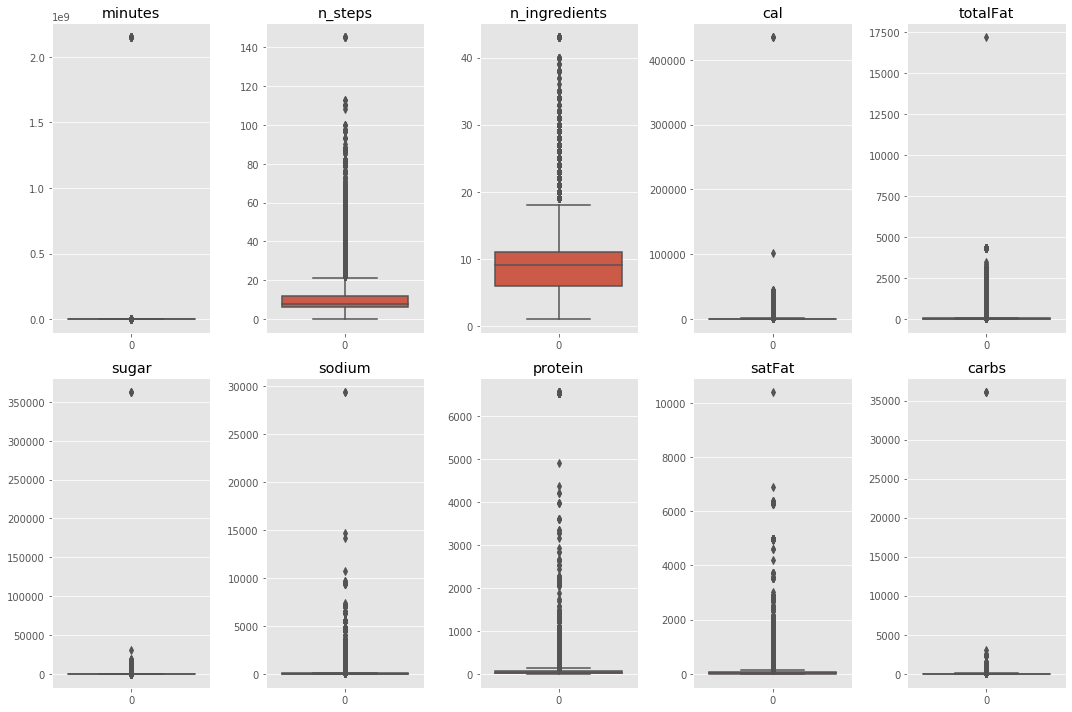

In [18]:
#Get all numeric columns
numeric_columns = ['minutes', 'n_steps', 'n_ingredients', 'cal', 'totalFat', 'sugar', 'sodium', 'protein', 'satFat', 'carbs']

plt.style.use('ggplot')
fig, axis = plt.subplots(2,5,figsize=(15,10))
axis = axis.ravel()
for i,ax in enumerate(axis):
    sns.boxplot(data=Merged_Data2[numeric_columns[i]],ax=ax)
    ax.set(title=numeric_columns[i])
plt.tight_layout()
plt.show()

**There are many outliers, so we should remove outliers**

**To remove the outliers i will set my lower and upper bound as : lower bound = Q1 - 1.5 * IQR upper bound = Q3 + 1.5 * IQR.**


**The values out of these range are considered as outliers and we have to remove them.**


In [0]:
# Removing values according to IQR
Columns_Remove_Outliers=['n_steps','minutes','n_ingredients','cal', 'totalFat', 'sugar',   'sodium', 'protein', 'satFat', 'carbs']
for col in Columns_Remove_Outliers:
    IQR = Merged_Data2[col].quantile(0.75) - Merged_Data2[col].quantile(0.25)
    colmax = Merged_Data2[col].quantile(0.75) + 1.5 * IQR
    colmin = Merged_Data2[col].quantile(0.25) - 1.5 * IQR
    Merged_Data2 = Merged_Data2[ (Merged_Data2[col] < colmax) & (Merged_Data2[col] > colmin) ]


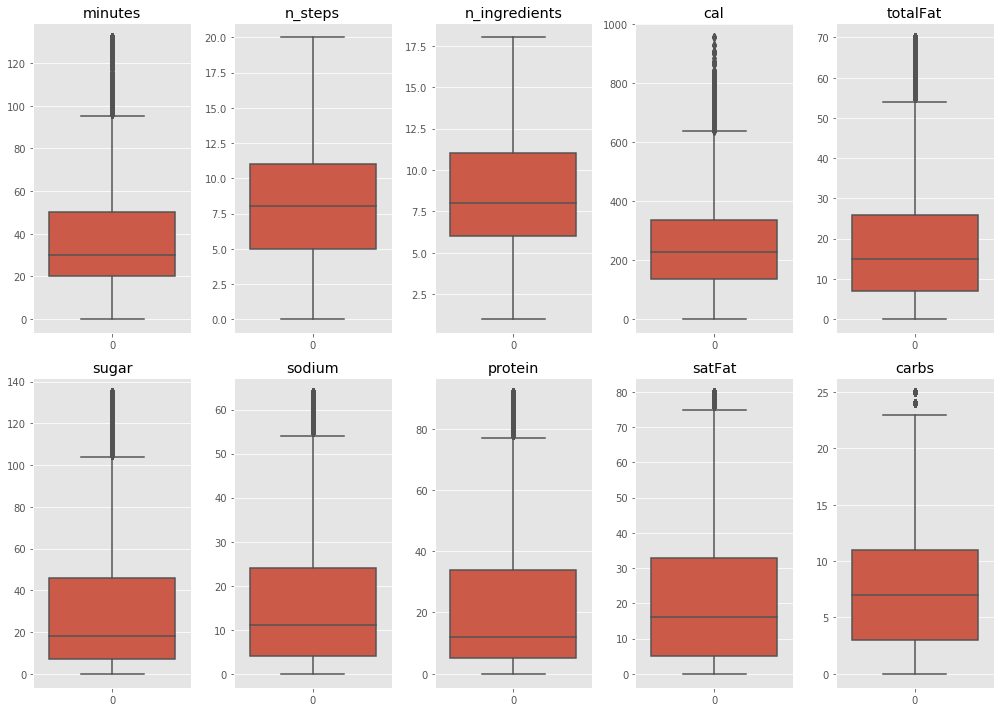

In [20]:
#Now we will look at distributions again
plt.style.use('ggplot')
fig, axis = plt.subplots(2,5,figsize=(14,10))
axis = axis.ravel()
for i,ax in enumerate(axis):
    sns.boxplot(data=Merged_Data2[numeric_columns[i]],ax=ax)
    ax.set(title=numeric_columns[i])
plt.tight_layout()
plt.show()

**This is much better than before removing the outliers**

**Removing Missing Values**

In [0]:
Merged_Data2.dropna(inplace= True)

**We can get many more insights from the data if we use the text in the reviews, Ingredients**



# Sentiment Classification

**Objective of the text analysis task we are trying to do:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).**


**But how to determine if a review is positive or negative?**

**We could use the Rating column. A rating of 4 or 5 can be cosnidered a positive review. A review of 1 or 2 can be considered as a negative review. A review of 3 is nuetral and ignored.** 

**This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.**

In [22]:
# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
Merged_Data2['rating_positive_negative'] = Merged_Data2['rating'].apply(partition)
Merged_Data2['rating_positive_negative'].value_counts()



1    620549
0     47618
Name: rating_positive_negative, dtype: int64

**The issue of class imbalance can result in a serious bias towards the majority class, reducing the classification performance and increasing the number of false negatives**

**But, we should remember that this sampling doesn't introduce new information in the dataset, it (hopefully) merely shifts it around so as to increase the "numerical stability" of our resulting models.**

**We do under-sampling the majority class as this will result in an improved classification performance.**

**Before doing all these splitting we have to preprocess the data so that every split of data have undergone through same data manipulations**

# Text Preprocessing

In the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)
After which we collect the words used to describe positive and negative reviews

In [0]:
#we are removing the words from the stop words list: 'no', 'nor', 'not'

STOP_WORDS= set([ 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])


porter = PorterStemmer()
wnl = WordNetLemmatizer()
def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    x = re.sub("\S*\d\S*", "", str(x)).strip()
    x = re.sub('[^A-Za-z0-9]+', ' ', str(x))
    #Stop word removal and Applying PorterStemmer
    #x = ' '.join(porter.stem(w) for w in x.split() if w not in STOP_WORDS)

    #Stop word removal and Applying WordNetLemmatizer
    x = ' '.join(wnl.lemmatize(w) for w in x.split() if w not in STOP_WORDS)
  
    return x


**Using the above function for review text pre processing**

In [0]:
Merged_Data2['Processed_Review'] = Merged_Data2['review'].apply(preprocess)

**Review Before Text Processing**

In [25]:
Merged_Data2['review'].values[2]

'Excellent recipe! I used butternut squash and the sweet option. The mexican spice mix put this over the top. Thanks for sharing.'

**Review after Text Processing**

In [26]:
Merged_Data2['Processed_Review'].values[2]

'excellent recipe used butternut squash sweet option mexican spice mix put top thanks sharing'

In [27]:
Merged_Data2.head(n=5)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,user_id,recipe_id,date,rating,review,cal,totalFat,sugar,sodium,protein,satFat,carbs,rating_positive_negative,Processed_Review
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"winter squash,mexican seasoning,mixed spice,ho...",7,4470,137739,2006-02-18,5,I used an acorn squash and recipe#137681 Swee...,51.5,0.0,13.0,0.0,2.0,0.0,4.0,1,used acorn squash sweet mexican spice blend us...
1,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"winter squash,mexican seasoning,mixed spice,ho...",7,593927,137739,2010-08-21,5,This was a nice change. I used butternut squas...,51.5,0.0,13.0,0.0,2.0,0.0,4.0,1,nice change used butternut squash sweet option...
2,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"winter squash,mexican seasoning,mixed spice,ho...",7,178427,137739,2011-12-05,5,Excellent recipe! I used butternut squash and ...,51.5,0.0,13.0,0.0,2.0,0.0,4.0,1,excellent recipe used butternut squash sweet o...
3,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"prepared pizza crust,sausage patty,eggs,milk,s...",6,28603,31490,2002-08-19,0,"Have not tried this, but it sounds delicious. ...",173.4,18.0,0.0,17.0,22.0,35.0,1.0,0,not tried sound delicious reminds layover atla...
4,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"prepared pizza crust,sausage patty,eggs,milk,s...",6,346277,31490,2006-08-27,5,This recipe was wonderful. Instead of using t...,173.4,18.0,0.0,17.0,22.0,35.0,1.0,1,recipe wonderful instead using precooked sausa...


**Now the text is pre processed and ready for modeling!**


**We will first divide the dataset into Test Train sets and perform undersampling only on the training set.**

 **We will keep test set aside for our model performance measurement.**

In [28]:
Y = Merged_Data2['rating_positive_negative'].values
X = Merged_Data2['Processed_Review'].values
X_train, X_test, y_train, y_test = train_test_split(X.astype('U'), Y, test_size=0.33) # this is random splitting
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(447671,) (447671,)
(220496,) (220496,)


**Performing Under Sampling on majority class of train set**

In [29]:
from imblearn.under_sampling import RandomUnderSampler
UnderSampler = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = UnderSampler.fit_resample(X_train.reshape(-1, 1), y_train)
print(X_resampled.shape, y_resampled.shape)
print("Value Counts",np.unique(y_resampled, return_counts=True, axis=None))


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(63902, 1) (63902,)
Value Counts (array([0, 1]), array([31951, 31951]))


In [0]:
X_resampled = X_resampled.ravel()

**As we can see from above value counts of y_resampled, our train set is balanced.**

**Now we got a Balanced dataset to train our models on!**

# Featurization

Now we will use different methods to convert the review text to vector

# Bag of words

In [0]:
def BOW(X_train, X_test):
  ''' Vectorize text using BOW count vectorizer'''
  vectorizer = CountVectorizer()
  # we use the fitted CountVectorizer to convert the text to vector
  X_train_bow = vectorizer.fit_transform(X_train)
  X_test_bow = vectorizer.transform(X_test)
  print("After vectorizations")
  print(X_train_bow.shape)
  print(X_test_bow.shape)

In [0]:
BOW(X_resampled, X_test = X_test )

After vectorizations
(63680, 27960)
(220496, 27960)


# Applying KNN

In [0]:


train_auc = []
test_auc = []
K = [1]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i,n_jobs=-1)
    neigh.fit(X_train_bow, y_train)
    y_train_pred =  neigh.predict_proba(X_train_bow)[:,1]
    y_test_pred =  neigh.predict_proba(X_test_bow)[:,1]
  
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    test_auc.append(roc_auc_score(y_test, y_test_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, test_auc, label='Test AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

NameError: ignored

# TF-IDF

In [0]:
def TFIDF(preprocessed_reviews):
      '''applying TF-IDF Vectorization on our corpus '''
      tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=0.01, max_df = 0.99, max_features = 5000)
      tf_idf_vect.fit(preprocessed_reviews)
      print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
      print('='*50)
      final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
      print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
      print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

In [37]:
TFIDF(X_resampled)

some sample features(unique words in the corpus) ['absolutely', 'actually', 'add', 'added', 'adding', 'addition', 'almond', 'almost', 'along', 'already']
the shape of out text TFIDF vectorizer  (63902, 473)
the number of unique words including both unigrams and bigrams  473


#  Building Word2Vec Model using our own text corpus

In [0]:

def Word2VecOnCorpus(sentences):
  ''' train my own Word2Vec model using our processed reviews text corpus '''
   #Preparing Reviews for gensim model 
  list_of_sentance_train=[]
  for sentance in sentences:
      list_of_sentance_train.append(sentance.split())

  # this line of code trains your w2v model on the give list of sentances
  w2v_model=Word2Vec(list_of_sentance_train,min_count=4,size=100, workers=4)

  w2v_words = list(w2v_model.wv.vocab)
  print("Number of words that occured minimum 4 times ",len(w2v_words))
  print("sample words ", w2v_words[0:50])
  print('='*50)
  print('Similar words to the given word using cosine similarity to investigate the learned representations')
  print(w2v_model.wv.most_similar('great'))
  print('='*50)
  print(w2v_model.wv.most_similar('bad'))

In [47]:
Word2VecOnCorpus(X_resampled)

Number of words that occured minimum 4 times  9508
sample words  ['not', 'going', 'give', 'star', 'made', 'change', 'may', 'affected', 'outcome', 'omitted', 'raisin', 'completely', 'used', 'oat', 'bran', 'instead', 'wheat', 'cup', 'whole', 'flour', 'added', 'half', 'quest', 'multi', 'purpose', 'mix', 'protein', 'powder', 'honey', 'rather', 'molasses', 'followed', 'recipe', 'instruction', 'got', 'muffin', 'no', 'idea', 'unless', 'making', 'jumbo', 'filled', 'top', 'batter', 'worried', 'overflow', 'rise', 'much', 'see', 'picture']
Similar words to the given word using cosine similarity to investigate the learned representations
[('wonderful', 0.8030920624732971), ('fantastic', 0.7608869075775146), ('excellent', 0.7321001291275024), ('awesome', 0.7253955602645874), ('perfect', 0.674199104309082), ('fabulous', 0.6526985168457031), ('terrific', 0.6419394016265869), ('good', 0.6297992467880249), ('nice', 0.6283421516418457), ('amazing', 0.6130922436714172)]
[('awful', 0.7682255506515503), ('

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


# Building Word2Vec Model using our own text corpus and Computing average word2vec for each review by averaging vectors of all words in that review

In [0]:
def AvgWord2VecRep(sentences):

    '''train my own Word2Vec model using our processed reviews text corpus and compute average word2vec for each review by averaging vectors of all words in that review'''
     #Preparing our text for gensim model 
    list_of_sentance_train=[]
    for sentance in sentences:
      list_of_sentance_train.append(sentance.split())

    #Building Word2Vec Model using our own text corpus  
    w2v_model=Word2Vec(list_of_sentance_train,min_count=4,size=100, workers=4)
    w2v_words = list(w2v_model.wv.vocab)

    #Averaging word vectors of a sentence
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_sentance_train): # for each review/sentence
        sent_vec = np.zeros(100) # as word vectors are of zero length 100
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    sent_vectors_train = np.array(sent_vectors)
    print(sent_vectors_train.shape)
    print(sent_vectors[0])

In [60]:
AvgWord2VecRep(X_resampled)

100%|██████████| 63902/63902 [00:38<00:00, 1676.08it/s]


(63902, 100)
[-0.12535977 -0.09503609 -0.54067013  0.09093773 -0.51132879  0.39970744
  0.1639934  -0.75317852  0.29356715 -0.50492466  0.07289449  0.36223845
  0.2375439  -0.53234591  0.27027627  0.41108286  0.35801443 -0.16447154
 -0.06591806  0.00480968  0.24977905 -0.1088526   0.2255481   0.3209452
  0.4723125   0.11743004 -0.11512359  0.01229464  0.37794113  0.09126035
  0.25751278 -0.2312575   0.1226084  -0.095356    0.17397889  0.24892482
 -0.00713888  0.29591088  0.0898548   0.63095197 -0.70102439  0.31179404
  0.1396902   0.22075798 -0.32701678 -0.09750071 -0.25212101 -0.17853189
 -0.59353396  0.01573257 -0.1990064  -0.09277693  0.02503603  0.47933579
 -0.35230679  0.11335168 -0.36420106  0.11353294  0.30231351 -0.13467028
 -0.21160416 -0.28221591  0.35144933 -0.04504559 -0.63040315  0.67262007
 -0.15678429  0.25194151  0.15592533 -0.39932983  0.14517364  0.01689153
  0.30817381 -0.07959943 -0.48513103  0.31755597 -0.55217524 -0.93964564
 -0.25273027  0.13769906 -0.02733334  0

# Converting Test data Text to Avg W2V

In [0]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])

100%|██████████| 70403/70403 [03:41<00:00, 318.46it/s]


(70403, 50)
[ 0.06297215 -0.14192812  0.3836453  -0.55301831  0.40639271 -1.53408594
  0.35516252  0.02975723  0.2449142   0.15138074  1.30457036 -0.65565635
  0.51124815 -0.36111175  0.45730648 -0.12929303 -0.70568492 -0.20468715
 -0.65196246  0.7446377  -0.30352508 -0.37555625 -0.09464471  0.66679685
  1.56915558 -0.70198115 -0.98964007  0.39259458 -0.68566521 -0.4410602
  0.48603958  0.25396468 -0.03244009 -1.53565942  1.21982544 -1.66362152
  0.30117046  0.53575364 -0.13249347  0.1809834   0.59287867 -0.50167001
  0.38422367  0.41541638 -0.19179391 -0.24636281 -0.31776545  0.81752866
  0.02406063 -1.14643323]


# Prediction using KNN(Avg W2V)

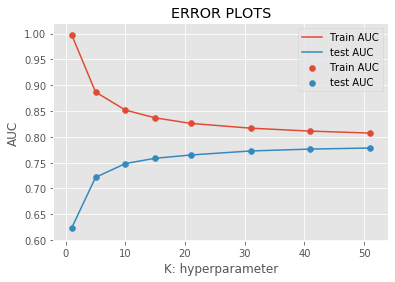

In [0]:
train_auc = []
test_auc = []
K = [1, 5, 10, 15, 21, 31, 41, 51]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i, n_jobs = -1)
    neigh.fit(sent_vectors_train, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(sent_vectors_train)[:,1]
    y_test_pred =  neigh.predict_proba(sent_vectors_test)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    test_auc.append(roc_auc_score(y_test, y_test_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.scatter(K, train_auc, label='Train AUC')
plt.plot(K, test_auc, label='test AUC')
plt.scatter(K, test_auc, label='test AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [0]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, neigh.predict(sent_vectors_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(sent_vectors_test)))

Train confusion matrix
[[13341 29086]
 [ 3186 97325]]
Test confusion matrix
[[ 6389 14526]
 [ 1768 47720]]


In [0]:
X_resampled,

# TFIDF weighted Word2Vec


In [0]:
def TfIdfWeightedW2V(preprocessed_text):

  '''Tf-Idf Weighted word2vec building for each sentence/review'''
  #TF-IDF Vectors
  model = TfidfVectorizer(ngram_range=(1,2), min_df=0.005, max_df = 0.99, max_features = 10000)
  model.fit(preprocessed_text)
  # we are converting a dictionary with word as a key, and the idf as a value
  dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
  tfidf_features = model.get_feature_names() # tfidf words/col-names

  #Preparing our text for gensim model 
  list_of_sentance_train=[]
  for sentance in preprocessed_text:
      list_of_sentance_train.append(sentance.split())

  #Building Word2Vec Model using our own text corpus  
  w2v_model=Word2Vec(list_of_sentance_train,min_count=4,size=100, workers=4)
  w2v_words = list(w2v_model.wv.vocab)

  tfidf_W2V_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list

  for sent in tqdm(list_of_sentance_train): # for each review/sentence 
      sent_vec = np.zeros(100) # as word vectors are of Length 100
      weight_sum =0; # num of words with a valid vector in the sentence/review
      for word in sent: # for each word in a review/sentence
          if word in w2v_words and word in tfidf_features:
              vec = w2v_model.wv[word]

              #dictionary[word] is idf value of word in whole courpus
              #sent.count(word) is tf valeus of word in this review/sentence
              tf_idf = dictionary[word]*(sent.count(word)/len(sent))
              sent_vec += (vec * tf_idf)
              weight_sum += tf_idf
      if weight_sum != 0:
          sent_vec /= weight_sum
      tfidf_W2V_sent_vectors.append(sent_vec)
      
  return tfidf_W2V_sent_vectors
      

In [69]:
tfidf_W2V_sent_vectors = TfIdfWeightedW2V(X_resampled)

100%|██████████| 63902/63902 [01:02<00:00, 1020.19it/s]


In [70]:
tfidf_W2V_sent_vectors[0]

array([ 0.53045935, -0.5404408 , -1.55853399,  1.33124348, -0.16212338,
        0.32128793, -0.24159047, -1.71393567,  1.09403364, -1.07622984,
        0.09043559, -0.26972247,  0.6010062 , -1.08662122,  0.25033073,
        0.31587715,  0.20809326, -0.03583285,  0.59316889,  0.33626832,
        1.11035254,  0.15047155,  0.73141743,  1.1652413 ,  0.61817892,
       -0.21271663,  1.50037432, -0.94254742,  0.74082806,  0.72272453,
        0.85469719, -0.02323947,  0.52124485, -0.94718612,  0.10754028,
        0.7958762 ,  0.84974503, -0.09173304, -0.10240901,  1.69454834,
       -2.0589952 ,  0.1982641 ,  0.59665584,  0.4226367 , -0.88671442,
       -0.4489793 , -0.18068908, -1.01065682, -1.28642632, -0.37573939,
       -0.54925411, -0.19638848,  0.48178927,  0.46933747, -0.2212466 ,
        0.45989831, -0.90667984, -0.15315247,  0.2350989 ,  0.22071033,
       -0.96148831,  0.96366518,  0.24630393,  0.22846309, -0.96392517,
        0.92251167, -0.69325482, -0.3261555 ,  0.63523868, -1.59

# Prediction using KNN (TF-IDF Weighted W2V)

In [0]:
train_auc = []
test_auc = []
K = [1, 21,41, 51]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i, n_jobs = -1)
    neigh.fit(sent_vectors_train, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(sent_vectors_train)[:,1]
    y_test_pred =  neigh.predict_proba(sent_vectors_test)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    test_auc.append(roc_auc_score(y_test, y_test_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.scatter(K, train_auc, label='Train AUC')
plt.plot(K, test_auc, label='test AUC')
plt.scatter(K, test_auc, label='test AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [0]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, neigh.predict(sent_vectors_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(sent_vectors_test)))

#Feature Engineering Cuisine

Surprisingly there is no Cuisine information in the data. 

It would be very helpful if we know which cuisine a recipe belongs to. So that we can further analyze things like which cuisine have more positive reviews, which cuisine have high nutritional value etc.


I've searched the datasets which contain cusine information and found a dataset that has ingredients and cuisine information.

We can use that data to train a model and use that model to predict cuisines for our dataset.

Let's start by importing it.

In [0]:
train_Cuisines = pd.read_json('/content/drive/My Drive/Colab Notebooks/Food_Data/train.json')
train_Cuisines.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


As we are dealing with textual data we have to vectorize ingreidents text.

For this we will use TF-IDF Vectorizer instad of count vectorizer as it will take into consideration the Frequency of words in document(TF) and also the frequency in all corpus documents(IDF)

In [0]:
train_Cuisines['ingredient_list'] = [','.join(z).strip() for z in train_Cuisines['ingredients']]

ingredients = train_Cuisines['ingredient_list']

Tfidfvectorizer = TfidfVectorizer(stop_words='english')

tfidf_dense_matrix= Tfidfvectorizer.fit_transform(ingredients).todense()
cuisines = train_Cuisines['cuisine']

print("TF-IDF Matrix looks like below :\n",tfidf_dense_matrix,"\n")
print("Cuisine looks like below :\n",cuisines.head(),"\n")

TF-IDF Matrix looks like below :
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] 

Cuisine looks like below :
 0          greek
1    southern_us
2       filipino
3         indian
4         indian
Name: cuisine, dtype: object 



In [0]:
tfidf_dense_matrix.shape

(39774, 2970)

We will use Random forest model and train a model to predict cuisines given ingredients

First we will split dataset into train and test sets.

We will use train set for hyper parameter tuning and cross validation.


We will use test set to see how well our trained model performs on unseen data

In [0]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_dense_matrix, cuisines, test_size=0.3)


def train_model(model, feature_df, target_df, num_procs, Accuracy ):
    Accuracy[model] = np.mean( cross_val_score(model, feature_df, target_df, cv=5, n_jobs=num_procs, scoring= 'accuracy'))
    
def TestSet_Results(model,X_train, X_test, y_train, y_test ):
      model.fit(X_train,y_train)
      Test_pred = model.predict(X_test)
      Accuracy[model] = accuracy_score(y_test,Test_pred)
      print('Test Accuracy:\n', Test_Accuracy[model])
def print_summary(model, Accuracy):
    print('\nModel:\n', model)
    print('Average Accuracy:\n', Accuracy[model])     

#initialize model list and dicts
models = []
Accuracy = {}
res = {}
Test_Accuracy = {}
#define number of processes to run in parallel
num_procs = 2

#shared model paramaters
verbose_lvl = 0


RandomForest = RandomForestClassifier()
XGB_Classifier =XGBClassifier()
                      
models.extend([RandomForest, XGB_Classifier])


In [0]:
#parallel cross-validate models, using MSE as evaluation metric, and print summaries
print("Beginning cross validation")
for model in models:
    train_model(model, X_train, y_train, num_procs, Accuracy)
    TestSet_Results(model,X_train, X_test, y_train, y_test)
    print_summary(model, Accuracy)

Beginning cross validation


KeyError: ignored

Random forest model has the best accuracy scores

So, we will use that to finally train on all the train data and test it on test set to see it's per class recall and precision

In [0]:
model = RandomForestClassifier()
model.fit(X_train,y_train)
Test_pred = model.predict(X_test)

print("mtest set accuracy : ",accuracy_score(y_test, Test_pred))
cuisines = train_Cuisines['cuisine'].value_counts().index
print(classification_report(y_test, Test_pred, target_names=cuisines))

As we trained our model with the TF_IDF vectorizer we must use the same for Recipe predictions on full Food.com Dataset 

In [0]:

#Vectorize ingredients based on previously fitted Tfidfvectorizer
ingredients_matrix = Tfidfvectorizer.transform(Merged_Data2['ingredients'])


#Use previously created randomforest model trained on kaggle cuisine data
cuisines_for_ingredients = model.predict(ingredients_matrix)


#Create new cuisine column in original dataframe
Merged_Data2['cuisine'] = cuisines_for_ingredients
Merged_Data2.head()

We added cuisine information for each recipe!!

Now we will look into various visuals that answer many questions regarding cusines.

Which cusine have average highest Ratings?

In [0]:
DataFrameVis = Merged_Data2.groupby('cuisine')['rating'].agg(['mean','count'])\
                                                        .rename(columns={"mean": "average_rating", "count": "No_of_Reviews"})
DataFrameVis.reset_index(inplace=True)    
DataFrameVis                                                 

In [0]:
fig , (ax1, ax2) = plt.subplots(1,2,figsize=(20,10))
plt.style.use('fivethirtyeight')
ax1.barh(y= DataFrameVis['cuisine'], width= DataFrameVis['average_rating'])
ax1.set(xlabel='Rating', ylabel='Cuisine ',title="Average rating per cuisine")


ax2.barh( y= DataFrameVis['cuisine'], width=DataFrameVis['No_of_Reviews'])
ax2.set(ylabel='Cuisine', xlabel='No_of_Reviews ',title="No_of_Reviews per cuisine")

plt.show()


Now we will see count of recipes we have for each cuisine in food.com

In [0]:
DataFrameVis = Merged_Data2.groupby('cuisine')['recipe_id'].nunique()
DataFrameVis = pd.DataFrame(DataFrameVis)
DataFrameVis.reset_index(inplace=True)
fig ,ax1 = plt.subplots(1,1,figsize=(10,10))
plt.style.use('fivethirtyeight')
ax1.barh(y= DataFrameVis['cuisine'], width= DataFrameVis['recipe_id'])
ax1.set(xlabel='Count of recipes', ylabel='Cuisine ',title="Count of recipes per cuisine")
#plt.xticks(rotation=65)

By looking at the above visualization we can clearly observe the domination of some cusines over other cusines and surprisingly we see similar ratings for each cusine.

We can further dive deep into this and we will see if we can find some interesting answers to questions like what king of recipes are rated high?

We can use clustering for this kind of un-supervised learning task.

# Clustering to Dig deep into recipe ratings

In [0]:
#Clustering by ingredients

#We will cluster data points using the ingredients data and see if we can find interesting patterns in those clusters

#Creating Vectorizer model, with taking top 1000 words from the ingredients text
vectorize = TfidfVectorizer(max_features= 1000, stop_words='english')

ingredients_matrix = vectorize.fit_transform(Merged_Data2['ingredients'])

#Converting the spared matrix to dense matrix and creating pandas DF from it
ingredients_DF = pd.DataFrame(ingredients_matrix.todense(),index=Merged_Data2.index)
ingredients_DF.columns=vectorize.get_feature_names()
ingredients_DF.head(10)



,10,acorn,active,added,adobo,agave,albacore,ale,alfredo,allspice,almond,almonds,aluminum,amaretto,amarula,american,ancho,anchovy,andouille,angel,anise,apple,apples,applesauce,apricot,apricots,arborio,artichoke,artichokes,artificial,arugula,asiago,asparagus,avocado,avocados,baby,bacon,bag,bagels,bags,...,walnut,walnuts,warm,wasabi,water,watercress,watermelon,wax,wedge,wedges,weed,wheat,whip,whipped,whipping,whiskey,white,whites,wide,wild,wine,wings,wonton,wooden,worcestershire,wrap,wrappers,wraps,xanthan,yams,yeast,yellow,yoghurt,yogurt,yolk,yolks,yukon,zest,ziti,zucchini
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.132957,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.214392,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.193442,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.222627,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.193442,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.222627,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
# Using truncated SVD ON sparce matrix to reduce the dimentionality of data

from sklearn.decomposition import TruncatedSVD
model = TruncatedSVD(n_components = 60)
ingredients_DF = model.fit_transform(ingredients_DF)


Now we should find optimal no of clusters(k) for k-means clustering

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


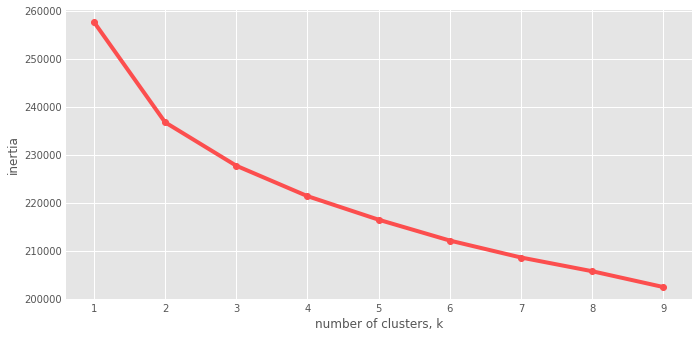

In [0]:


#Passing the vectorized matrix created above to k-Means model for clustering
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k, random_state=0, n_jobs = -1)
    
    # Fit model to samples
    model.fit(ingredients_DF)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.style.use('ggplot')
plt.figure(figsize=(10,5))
plt.plot(ks, inertias, '-o', color='#FC4E4E')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()


From the above plot, we cannot discern a K value easily. Even though the graph is not straightforward, we have reasonable doubt between values 4,5 & 6.

In this case, we will need another method to find the optimal K from the values 4,5 & 6.

We will use the silhouette score.

Silhouette method measures how similar a point is to it’s own cluster compared to others.
It is more likely a validation rather than a decision maker. Which is exactly what we want in this scenario.

By using Euclidean distance as the metric, we will plot the graph for silhouette scores for the three values of K.

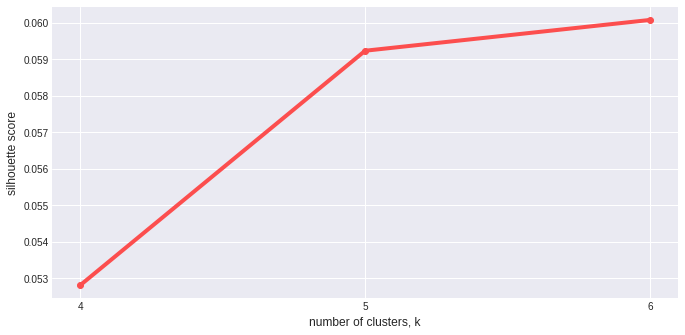

In [0]:

#Passing the vectorized matrix created above to k-Means model for clustering
kvalue = range(4, 7)
sil = []

for k in kvalue:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k, random_state=0)
    
    # Fit model to samples
    model.fit(ingredients_DF)
    labels = model.labels_
    sil.append(silhouette_score(ingredients_DF, labels, metric = 'euclidean'))

plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(10,5))
plt.plot(kvalue, sil, '-o', color='#FC4E4E')
plt.xlabel('number of clusters, k')
plt.ylabel('silhouette score')
plt.xticks(kvalue)
plt.show()


From the above graph, we can say that the 6 is the most optimal value for K.

In [0]:
model = KMeans(n_clusters=6, random_state=0)
model.fit(ingredients_DF)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

The number of recipes in each cluster

In [0]:
Merged_Data2['ingredients_Cluster'] = model.labels_
Merged_Data2['ingredients_Cluster'].value_counts()

NameError: ignored

Now we will look at top-ingredients in each of our clusters.

In [0]:
print('\nCrucial ingredients for each clusters: \n')
features = vectorize.get_feature_names()
centroids = model.cluster_centers_.argsort()[:,::-1]
for clust in range(0,6):
    print('Cluster '+str(clust)+': ')
    for ind in centroids[clust, :15]:
        print(features[ind]+' ', end='')
    print()
    print()


Crucial ingredients for each clusters: 

Cluster 0: 
10 added ale apricots albacore ancho aluminum bars artichokes baked asiago barbecue bag artichoke baileys 

Cluster 1: 
10 adobo applesauce almond ancho almonds arborio artificial asparagus andouille barbecue bagels base alfredo bag 

Cluster 2: 
10 acorn almonds ale allspice almond artificial angel apricot artichokes asiago apricots anchovy amarula avocado 

Cluster 3: 
10 acorn adobo albacore agave amaretto artichoke apple alfredo anise bacon apples applesauce arborio ancho 

Cluster 4: 
10 agave alfredo added active american allspice almond amaretto anise asiago andouille bacon bagels banana 

Cluster 5: 
10 active angel albacore adobo anchovy amarula arborio amaretto baby basmati bag arugula apples barley 



Summarizing the data on Cluster number to look at some properties

In [0]:
results = Merged_Data2.groupby(['ingredients_Cluster']).mean().sort_values("mean_rating",ascending=True)
results

# Market Baset Analysis on Ingredients using Apriori

If This Food.com wants to sell ingredients then when is the  best we we can increase the sales of the ingredients?

We should find a way to recommend additional products to customers based on what they have in cart.

The best way to do this is by using market basket analysis by implementing Apriori algorithm.

As we already have the common ingredients for a recipe as a list. We can use those lists to give input to apriori algorithm for it to learn the associations.

In [0]:


Merged_Data2['ingredient_list'] = [z.split(",") for z in Merged_Data2['ingredients']]



In [0]:
Merged_Data2['ingredient_list'][1:888]


1       [winter squash, mexican seasoning, mixed spice...
2       [winter squash, mexican seasoning, mixed spice...
3       [prepared pizza crust, sausage patty, eggs, mi...
4       [prepared pizza crust, sausage patty, eggs, mi...
5       [prepared pizza crust, sausage patty, eggs, mi...
                              ...                        
1783         [ouzo, orange juice, ice cube, orange slice]
1784         [ouzo, orange juice, ice cube, orange slice]
1785         [ouzo, orange juice, ice cube, orange slice]
1786         [ouzo, orange juice, ice cube, orange slice]
1787         [ouzo, orange juice, ice cube, orange slice]
Name: ingredient_list, Length: 887, dtype: object

I tried many parameter values of Support, Confidence and Lift for apriori model.I've selected min_support to be 0.0060, min_confidence=0.6, min_lift=3 as desired values for our Apriori algorithm.

Running Apriori algorithm on the Ingredients list of lists 

In [0]:

associationRules = apriori(Merged_Data2['ingredient_list'], min_support=0.0040, min_confidence=0.4, min_lift=3, min_length=5,max_length=None)
associationResult = list(associationRules)

print("\n\nNumber of Rules:")
print(len(associationResult))

print("\n\nExample of a rule:")
print(associationResult[1])
print("\n\n")

associationResult10=associationResult[50:60]

print("Listing 10 rules:\n")
for item in associationResult10:
    pair = item[0] 
    items = [x for x in pair]
    print("Rule: " + items[0] + " --> " + items[1])
    print("Support: " + str(item[1]))
    print("Confidence: " + str(item[2][0][2]))
    print("Lift: " + str(item[2][0][3]))
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")



Number of Rules:
1021


Example of a rule:
RelationRecord(items=frozenset({'all-purpose flour', 'baking powder'}), support=0.03381220755096261, ordered_statistics=[OrderedStatistic(items_base=frozenset({'all-purpose flour'}), items_add=frozenset({'baking powder'}), confidence=0.40432326209776465, lift=4.1652134845024325)])



Listing 10 rules:

Rule: italian seasoning --> parmesan cheese
Support: 0.0048567265662943174
Confidence: 0.42528587948091995
Lift: 5.439721114741134
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Rule: onion --> lean ground beef
Support: 0.008271108052628722
Confidence: 0.6111231569817867
Lift: 3.697243291711925
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Rule: parmesan cheese --> mozzarella cheese
Support: 0.011751517543640844
Confidence: 0.5068345779015315
Lift: 6.4827893144652675
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Rule: red wine vinegar --> olive oil
Support: 0.005556623415878121
Confidence: 0.44060500290866783
Lift: 3.078300003355662
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Rule: sea

# References


*   https://stackabuse.comassociation-rule-mining-via-apriori-algorithm-in-python/

*   
https://www.kaggle.com/kaggle/recipe-ingredients-dataset/data#


*  remove urls from text python: https://stackoverflow.com/a/40823105/4084039 

* Extract text from html # https://stackoverflow.com/questions/16206380/

* python-beautifulsoup-how-to-remove-all-tags-from-an-element

* remove words with numbers python: https://stackoverflow.com/a/18082370/4084039

* remove spacial character: https://stackoverflow.com/a/5843547/4084039

*  decontract text # https://stackoverflow.com/a/47091490/4084039

